In [1]:
import ROOT
import math
from IPython.display import  Audio
sound_file= 'sounds/dscybsit.wav'

Welcome to JupyROOT 6.22/06


In [2]:
chain = ROOT.TChain

file = ROOT.TFile.Open("../output/Charmonium2018B_test/jpsi_charmonium_2018B.root")

## Mass fit

mass = ROOT.RooRealVar("mass", "", 2.95, 3.25)

#x_range = [2.95, 3.25]
#bin_widht = 30e-4
#n_bins = int((x_range[1] - x_range[0]) / bin_widht)
#mass.setBins(n_bins)

data = ROOT.RooDataSet("data", "", file.Jpsi, ROOT.RooArgSet(mass))


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

[#1] INFO:Eval -- RooAbsReal::attachToTree(mass) TTree Float_t branch mass will be converted to double precision
[#1] INFO:Eval -- RooTreeDataStore::loadValues(data) Ignored 170307 out of range events


In [3]:
#Signal PDFs

## Signal PDF: Crystal ball and gaussian

frac_gauss = ROOT.RooRealVar("frac_gauss","", 0.4, 0.0, 1.0)
mean = ROOT.RooRealVar("mean", "", 3.09355, 2.95, 3.25)
sigma_gauss = ROOT.RooRealVar("sigma gauss", "", 0.02, 0.000001, 1)

frac_cb = ROOT.RooRealVar("frac_cb","", 0.6, 0.0, 1.0)
sigma_cb = ROOT.RooRealVar("sigma cb", "", 0.02, 0.000001, 1)

alpha = ROOT.RooRealVar("alpha", "", 1.4, 0, 10)

n = ROOT.RooRealVar("n", "", 30, 0, 150)
n.setConstant(True)

signal1 = ROOT.RooGaussian("gauss", "", mass, mean, sigma_gauss)
signal2 = ROOT.RooCBShape("crystal ball", "", mass, mean, sigma_cb, alpha, n)

In [4]:
# Background PDF
exp_coef = ROOT.RooRealVar("exp_coef", "", -3, -5, 5)

back_exp = ROOT.RooExponential("back_exp", "", mass, exp_coef)

In [5]:
# Model definition and fitting
model = ROOT.RooAddPdf("model", "", ROOT.RooArgList(signal1, signal2, back_exp),
                       ROOT.RooArgList(frac_gauss, frac_cb), ROOT.kTRUE)

In [ ]:
result = model.fitTo(data, ROOT.RooFit.Save())

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (gauss,crystal ball)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (back_exp)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()


Info in <TCanvas::Print>: png file Jpsi_fit.png has been created


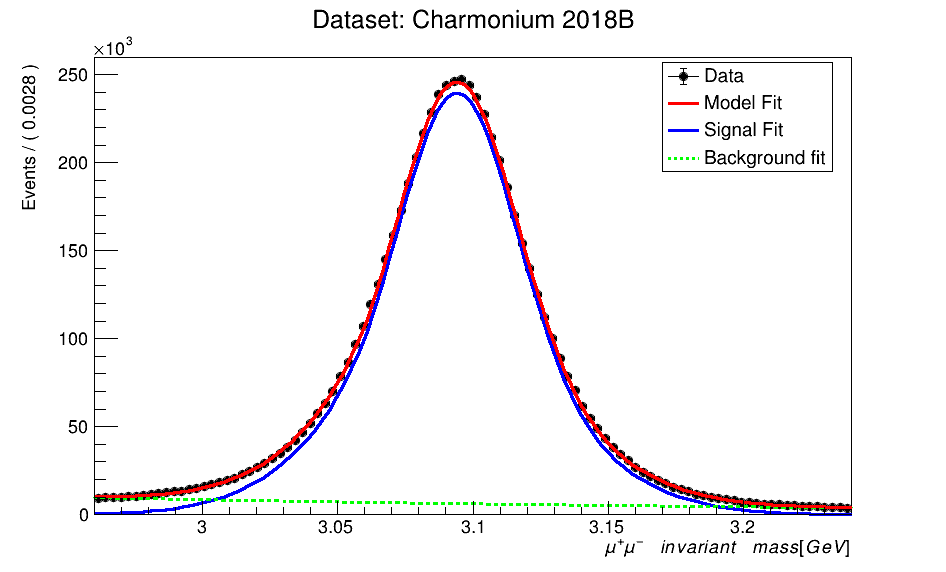

In [7]:
## Plots

# Colors and styles
colors = {"model" : 2, "signal" : 4, "background" : 3}
styles = {"model" : 1, "signal" : 1, "background" : 2}

# Canvas Definition
can = ROOT.TCanvas("can", "histograms", 950, 600)

# Frame creation
frame1 = mass.frame(ROOT.RooFit.Title("Dataset: Charmonium 2018B"), ROOT.RooFit.Bins(100))
frame1.GetXaxis().SetTitle("#\mu^+\mu^- #invariant \ mass[GeV]")

# Data
data.plotOn(frame1, ROOT.RooFit.Name("Data"), ROOT.RooFit.DataError(ROOT.RooAbsData.SumW2))

# Signal
model.plotOn(frame1, ROOT.RooFit.Name("Signal"), ROOT.RooFit.Components("gauss,crystal ball"), ROOT.RooFit.LineStyle(styles["signal"]), ROOT.RooFit.LineColor(colors["signal"]))

# Background
model.plotOn(frame1, ROOT.RooFit.Name("Background"), ROOT.RooFit.Components("back_exp"), ROOT.RooFit.LineStyle(styles["background"]), ROOT.RooFit.LineColor(colors["background"]))

# Model
model.plotOn(frame1, ROOT.RooFit.Name("Model"), ROOT.RooFit.LineStyle(styles["model"]), ROOT.RooFit.LineColor(colors["model"]))

## ChiSquare computation
n_param = result.floatParsFinal().getSize()
reduce_chi_square = frame1.chiSquare(n_param)
## Legends

leg = ROOT.TLegend(0.7, 0.7, 0.88, 0.89)
leg.AddEntry(frame1.findObject("Data"), "Data", "LEP")
leg.AddEntry(frame1.findObject("Model"), "Model Fit", "L")
leg.AddEntry(frame1.findObject("Signal"), "Signal Fit", "L")
leg.AddEntry(frame1.findObject("Background"), "Background fit", "L")

frame1.Draw()
leg.Draw("same")

can.Draw()

can.SaveAs("Jpsi_fit.png")

In [27]:
## yields computation

# M = fgauss * Gaussian + (1 - fgauss) [fcrystall * CrystallBall + (1 - fcrystall) * exponential]

# Number of signal events: Nsignal = Ntotal * [fcrystall + (1 - fcrystall) * fgauss]
nsignal = data.sumEntries() * (frac_cb.getVal() + (1 - frac_cb.getVal()) * frac_gauss.getVal())

# Number of background events: Nback = Ntotal (1 - fgauss) * (1 - fcrystall) * fexponential
# or Ntotal - Nsignal
nbackground = data.sumEntries() * (1 - frac_gauss.getVal()) * (1 - frac_cb.getVal())
r'$\alpha > \beta$'
print("The number of signal events is: {}".format(nsignal))
print("The number of background events is: {}".format(nbackground))
print("The number of s/sqrt(b) is : {}".format(nsignal/math.sqrt(nbackground)))

The number of signal events is: 6009139.837639108
The number of background events is: 643816.1623608916
The number of s/sqrt(b) is : 7489.130063199907


In [20]:
## Compute the effective sigma
# SigmaEff = fractionGauss * sigmaGauss + (1-fractionGauss) * sigmaCB
sigma_effective = (frac_gauss.getVal() * sigma_gauss.getVal()**2 + (1 - frac_gauss.getVal()) * sigma_cb.getVal()**2)**(0.5)
sigma_effective
# Ref: https://root-forum.cern.ch/t/how-to-calculate-effective-sigma/39472/3

0.031166543883814842

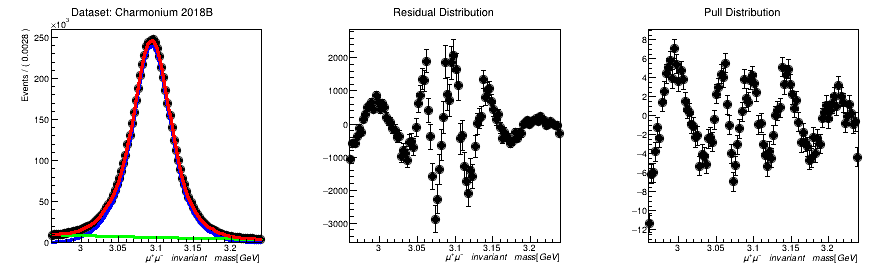

In [9]:
# Takes pull and residual histograms
histpull = frame1.pullHist()
histresid = frame1.residHist()

# New frame to draw residual distribution
frame2 = mass.frame(ROOT.RooFit.Title("Residual Distribution"))
frame2.GetXaxis().SetTitle()

frame2 = mass.frame(ROOT.RooFit.Title("Residual Distribution"))
frame2.GetXaxis().SetTitle("#\mu^+\mu^- #invariant \ mass[GeV]")

# Add the distribution to the frame
frame2.addPlotable(histresid, "P")

# New frame to draw pull distribution
frame3 = mass.frame(ROOT.RooFit.Title("Pull Distribution"))
frame3.GetXaxis().SetTitle("#\mu^+\mu^- #invariant \ mass[GeV]")

# Add the distribution to the frame
frame3.addPlotable(histpull, "P")

# New canvas to draw our distributions
can2 = ROOT.TCanvas("can2", "Residual_pull", 900, 300)
can2.Divide(3)

# Plot for data and fit
can2.cd(1)
ROOT.gPad.SetLeftMargin(0.15)
frame1.GetYaxis().SetTitleOffset(1.6)
frame1.Draw()

# Plot for residual distribution
can2.cd(2)
ROOT.gPad.SetLeftMargin(0.15)
frame2.GetYaxis().SetTitleOffset(1.6)
frame2.Draw()

# Plot for pull distribution

can2.cd(3)
ROOT.gPad.SetLeftMargin(0.15)
frame3.GetYaxis().SetTitleOffset(1.6)
frame3.Draw()

can2.Draw()

In [22]:
# To save workspace
wspace = ROOT.RooWorkspace("Dstar fit")

getattr(wspace, "import")(data)
getattr(wspace, "import")(model)

wspace.writeToFile("Jpsi_fit.root")

False

[#1] INFO:ObjectHandling -- RooWorkspace::import(Dstar fit) importing dataset data
[#1] INFO:ObjectHandling -- RooWorkspace::import(Dstar fit) importing RooRealVar::mass
[#1] INFO:ObjectHandling -- RooWorkspace::import(Dstar fit) importing RooAddPdf::model
[#1] INFO:ObjectHandling -- RooWorkspace::import(Dstar fit) importing RooGaussian::gauss
[#1] INFO:ObjectHandling -- RooWorkspace::import(Dstar fit) importing RooRealVar::mean
[#1] INFO:ObjectHandling -- RooWorkspace::import(Dstar fit) importing RooRealVar::sigma gauss
[#1] INFO:ObjectHandling -- RooWorkspace::import(Dstar fit) importing RooRealVar::frac_gauss
[#1] INFO:ObjectHandling -- RooWorkspace::import(Dstar fit) importing RooCBShape::crystal ball
[#1] INFO:ObjectHandling -- RooWorkspace::import(Dstar fit) importing RooRealVar::sigma cb
[#1] INFO:ObjectHandling -- RooWorkspace::import(Dstar fit) importing RooRealVar::alpha
[#1] INFO:ObjectHandling -- RooWorkspace::import(Dstar fit) importing RooRealVar::n
[#1] INFO:ObjectHandli

In [ ]:
Audio(sound_file, autoplay=True)

In [5]:
## Decay lenght fit

# Decay lenght 
jpsi_dl = ROOT.RooRealVar("jpsi_dl", "", -0.5, 1.30)

# Data
data = ROOT.RooDataSet("data", "", file.Jpsi, ROOT.RooArgSet(jpsi_dl))

[#1] INFO:Eval -- RooAbsReal::attachToTree(jpsi_dl) TTree Float_t branch jpsi_dl will be converted to double precision
[#1] INFO:Eval -- RooTreeDataStore::loadValues(data) Ignored 11580 out of range events


In [6]:
## First try: Gaussian + exponential
sigma_dl = ROOT.RooRealVar("sigma_dl", "", 0.01, 5)

## PDFs for prompt signal

# Gaussian 1
mean = ROOT.RooRealVar("mean", "", 0, -0.1, 0.1)
sigma1 = ROOT.RooRealVar("sigma1", "", 0.01, 0, 0.1)
frac1 = ROOT.RooRealVar("frac1", "", 0.5, 0, 0.1)
gauss1 = ROOT.RooGaussModel("gauss1", "", jpsi_dl, mean, sigma1, sigma_dl)

# Gaussian 2
sigma2 = ROOT.RooRealVar("sigma2", "", 0.01, 0, 0.1)
frac2 = ROOT.RooRealVar("frac2", "", 0.5, 0, 0.1)
gauss2 = ROOT.RooGaussModel("gauss2", "", jpsi_dl, mean, sigma2, sigma_dl)

# Prompt signal: Resolution function
prompt_signal = ROOT.RooAddModel("promtp_signal", "", ROOT.RooArgList(gauss1, gauss2),
                       ROOT.RooArgList(frac1), ROOT.kTRUE)

## PDFs for nomprompt signal

# Gaussian 3
mean_np = ROOT.RooRealVar("mean_nonprompt", "", 0, -0.1, 0.1)
sigma_np1 = ROOT.RooRealVar("sigma_np1", "", 0.01, 0, 0.1)
frac_np1 = ROOT.RooRealVar("frac_np1", "", 0.3, 0, 0.1)
gauss_np1 = ROOT.RooGaussModel("gauss_np1", "", jpsi_dl, mean_np, sigma_np1, sigma_dl)

## Reference to add model: https://root.cern/doc/master/rf209__anaconv_8C.html

In [14]:
# Exponential decay
tau = ROOT.RooRealVar("tau", "", 1.5, 0, 3)

# PDF for nompromt signal
frac_exp = ROOT.RooRealVar("frac_exp", "", 0.3, 0, 1)
exp_decay = ROOT.RooDecay("exp_decay", "", jpsi_dl, tau, gauss_np1, ROOT.RooDecay.SingleSided)

In [16]:
# Model pdf
model = ROOT.RooAddModel("model", "", ROOT.RooArgList(prompt_signal, exp_decay),
                                      ROOT.RooArgList(frac_exp), ROOT.kTRUE)

In [17]:
result = model.fitTo(data, ROOT.RooFit.ConditionalObservables(ROOT.RooArgSet(sigma_dl)))

[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 frac1        1.00000e-01  1.00000e-02    0.00000e+00  1.00000e-01
 MINUIT WARNING IN PARAM DEF
 ============== STARTING VALUE IS AT LIMIT.
 MINUIT WARNING IN PARAMETR
 ============== VARIABLE1 IS AT ITS UPPER ALLOWED LIMIT.
 MINUIT WARNING IN PARAMETR
 ============== VARIABLE1 BROUGHT BACK INSIDE LIMITS.
     2 frac_exp     3.00000e-01  1.00000e-01    0.00000e+00  1.00000e+00
     3 mean         0.00000e+00  2.00000e-02   -1.00000e-01  1.00000e-01
     4 mean_nonprompt   0.00000e+00  2.00000e-02   -1.00000e-01  1.00000e-01
     5 sigma1       1.00000e-02  5.00000e-03    0.00000e+00  1.00000e-01
     6 sigma_dl     2.50500e+00  4.99000e-01    1.00000e-02  5.00000e+00
     7 sigma_np1    1.00000e-02  5.00000e-03    0.00

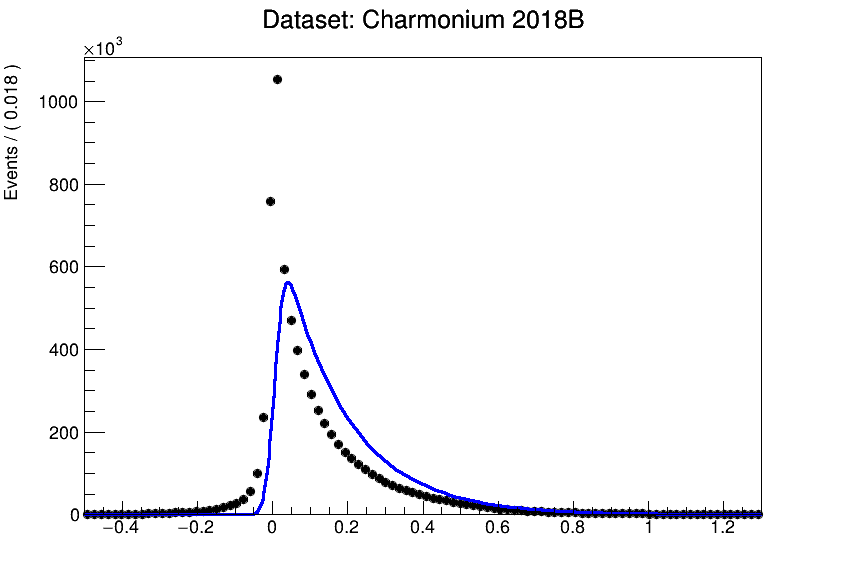

In [18]:
frame1 = jpsi_dl.frame(ROOT.RooFit.Title("Dataset: Charmonium 2018B"), ROOT.RooFit.Bins(100))
data.plotOn(frame1, ROOT.RooFit.Name("jpsi_dl"), ROOT.RooFit.DataError(ROOT.RooAbsData.SumW2))
exp_decay.plotOn(frame1,ROOT.RooFit.ProjWData(data) )

can = ROOT.TCanvas("can", "histograms", 850, 600)
can.Draw()
frame1.Draw()

In [18]:
# Model definition and fitting
model = ROOT.RooAddPdf("model", "", ROOT.RooArgList(resolution_function, nonprompt, background),
                       ROOT.RooArgList(frac_resolution_function, frac_nonprompt), ROOT.kTRUE)

In [ ]:
result = model.fitTo(data, ROOT.RooFit.Save())

[#0] ERROR:InputArguments -- RooPlot::findObject(frame_jpsi_dl_55db45c57000) cannot find object Data
[#0] ERROR:InputArguments -- RooPlot::findObject(frame_jpsi_dl_55db45c57000) cannot find object Model
[#0] ERROR:InputArguments -- RooPlot::findObject(frame_jpsi_dl_55db45c57000) cannot find object Signal
[#0] ERROR:InputArguments -- RooPlot::findObject(frame_jpsi_dl_55db45c57000) cannot find object Background


Warning in <TCanvas::Constructor>: Deleting canvas with same name: can
Info in <TCanvas::Print>: png file Jpsi_fit.png has been created


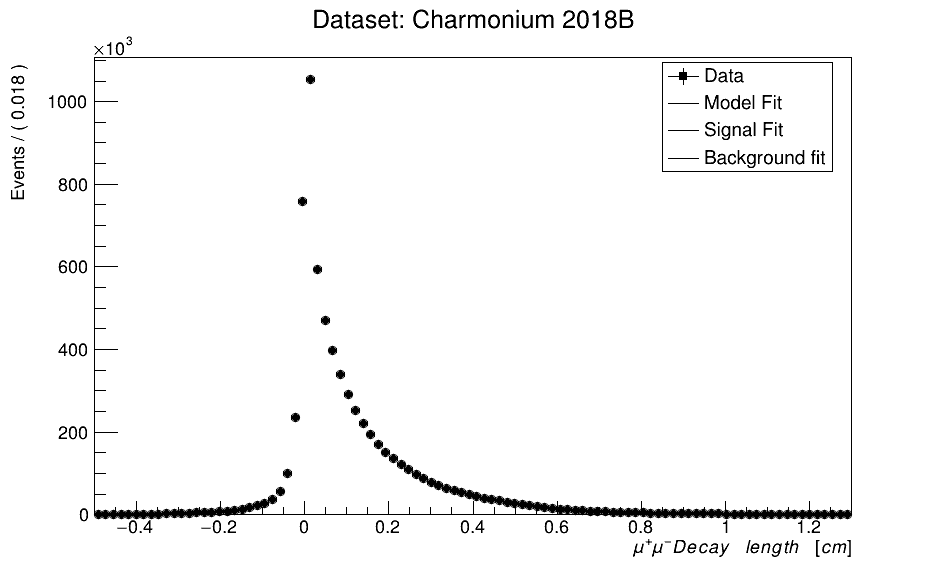

In [17]:
## Plots

# Colors and styles
colors = {"model" : 2, "prompt" : 4, "nonprompt" : 3, "background": 1}
styles = {"model" : 1, "prompt" : 1, "nonprompt" : 2, "background": 2}

# Canvas Definition
can = ROOT.TCanvas("can", "histograms", 950, 600)

# Frame creation
frame1 = jpsi_dl.frame(ROOT.RooFit.Title("Dataset: Charmonium 2018B"), ROOT.RooFit.Bins(100))
frame1.GetXaxis().SetTitle("#\mu^+\mu^- Decay \ length \ [cm]")

# Data
data.plotOn(frame1, ROOT.RooFit.Name("jpsi_dl"), ROOT.RooFit.DataError(ROOT.RooAbsData.SumW2))

# Prompt
#model.plotOn(frame1, ROOT.RooFit.Name("Prompt"), ROOT.RooFit.Components("resolution_function"), ROOT.RooFit.LineStyle(styles["prompt"]), ROOT.RooFit.LineColor(colors["prompt"]))

# Nonprompt
#model.plotOn(frame1, ROOT.RooFit.Name("Nonprompt"), ROOT.RooFit.Components("nonprompt"), ROOT.RooFit.LineStyle(styles["nonprompt"]), ROOT.RooFit.LineColor(colors["nonprompt"]))

# Background
#model.plotOn(frame1, ROOT.RooFit.Name("Background"), ROOT.RooFit.Components("background"), ROOT.RooFit.LineStyle(styles["background"]), ROOT.RooFit.LineColor(colors["background"]))

# Model
#model.plotOn(frame1, ROOT.RooFit.Name("Model"), ROOT.RooFit.LineStyle(styles["model"]), ROOT.RooFit.LineColor(colors["model"]))


## ChiSquare computation
#n_param = result.floatParsFinal().getSize()
#reduce_chi_square = frame1.chiSquare(n_param)
## Legends

leg = ROOT.TLegend(0.7, 0.7, 0.88, 0.89)
leg.AddEntry(frame1.findObject("Data"), "Data", "LEP")
leg.AddEntry(frame1.findObject("Model"), "Model Fit", "L")
leg.AddEntry(frame1.findObject("Signal"), "Signal Fit", "L")
leg.AddEntry(frame1.findObject("Background"), "Background fit", "L")

frame1.Draw()
leg.Draw("same")

can.Draw()

can.SaveAs("Jpsi_fit.png")

In [ ]:
############################################### Backup ######################################################################

## Prompt Signal PDF: Resolution function -> Sum of two gaussians

# Gaussian widht: decay lenght uncertainty (calculate this) * Scale factor

# uncertainty
#uncert = ROOT.RooRealVar("sigma", "Decay length uncertainty", 0.01, 0.001, 0.5)
#scale_factor1 = ROOT.RooRealVar("scale_factor1", "Global Scale Factor", 1, 0, 1.2)
#scale_factor2 = ROOT.RooRealVar("scale_factor2", "Global Scale Factor", 1, 0, 1.2)

# mean_dl
mean_prompt = ROOT.RooRealVar("mean", "", 0, -0.1, 0.1)
sigma1 = ROOT.RooRealVar("sigma1", 0.01, -0.1, 0.1)
sigma2 = ROOT.RooRealVar("sigma2", 0.01, -0.1, 0.1)
#sigma1 = ROOT.RooFormulaVar("sigma1", "@0*@1", ROOT.RooArgList(uncert, scale_factor1))
#sigma2 = ROOT.RooFormulaVar("sigma2", "@0*@1", ROOT.RooArgList(uncert, scale_factor2))

# Gaussians fractions
frac_gauss1 = ROOT.RooRealVar("frac_gauss1", "", 0.6, 0.0, 1.0)
frac_gauss2 = ROOT.RooRealVar("frac_gauss2", "", 0.5, 0.0, 1.0)

gauss1 = ROOT.RooGaussian("gauss1", "", dl, mean_prompt, sigma1)
gauss2 = ROOT.RooGaussian("gauss2", "", dl, mean_prompt, sigma2)

resolution_function_prompt = ROOT.RooAddPdf("resolution_function_prompt", "", ROOT.RooArgList(gauss1, gauss2), ROOT.RooArgList(frac_gauss1, frac_gauss2))
frac_prompt = ROOT.RooRealVar("frac_resolution_function_prompt", "", 0.6, 0.0, 1.0)

##  Nonprompt: Exponential convolved with an resolution function

# Exponential
exp_coef = ROOT.RooRealVar("exp_cof", "", -1.0, -4.0, 4.0)
exponential = ROOT.RooExponential("nonprompt_expo", "", dl, exp_coef)

## Resolution function for nonprompt

# uncertainty
#uncert = ROOT.RooRealVar("sigma", "Decay length uncertainty", 0.01, 0.001, 0.5)
#scale_factor1 = ROOT.RooRealVar("scale_factor1", "Global Scale Factor", 1, 0, 1.2)
#scale_factor2 = ROOT.RooRealVar("scale_factor2", "Global Scale Factor", 1, 0, 1.2)

# mean_dl
mean_nonprompt = ROOT.RooRealVar("mean", "", 0, -0.1, 0.1)
sigma1 = ROOT.RooRealVar("sigma1", 0.01, -0.1, 0.1)
sigma2 = ROOT.RooRealVar("sigma2", 0.01, -0.1, 0.1)
#sigma1 = ROOT.RooFormulaVar("sigma1", "@0*@1", ROOT.RooArgList(uncert, scale_factor1))
#sigma2 = ROOT.RooFormulaVar("sigma2", "@0*@1", ROOT.RooArgList(uncert, scale_factor2))

# Gaussians fractions
frac_gauss1 = ROOT.RooRealVar("frac_gauss1", "", 0.6, 0.0, 1.0)
frac_gauss2 = ROOT.RooRealVar("frac_gauss2", "", 0.5, 0.0, 1.0)

gauss1 = ROOT.RooGaussian("gauss1", "", dl, mean_prompt, sigma1)
gauss2 = ROOT.RooGaussian("gauss2", "", dl, mean_prompt, sigma2)

resolution_function_prompt = ROOT.RooAddPdf("resolution_function_prompt", "", ROOT.RooArgList(gauss1, gauss2), ROOT.RooArgList(frac_gauss1, frac_gauss2))
frac_resolution_function_prompt = ROOT.RooRealVar("frac_resolution_function_prompt", "", 0.6, 0.0, 1.0)

nonprompt = ROOT.RooFFTConvPdf ("nomprompt_conv", "", dl, resolution_function, exponential)
frac_nonprompt =  ROOT.RooRealVar("frac_nonprompt", "", 0.1, 0.0, 1.0)

## Background: Exponential decay function + resolution

#exp_decay_coef = ROOT.RooRealVar("exp_decay_coef", "", -0.5, -4, 4)
#exp_decay = ROOT.RooDecay("exp_decay", "", dl, exp_decay_coef, ,)
frac_exp_decay = ROOT.RooRealVar("frac_exp_decay", "", 0.1, 0.0, 1.0)

background = ROOT.RooAddPdf("background", "", ROOT.RooArgList(gauss1, gauss2, exponential), ROOT.RooArgList(gauss1, gauss2))

In [71]:
### Tesf for yields associated

save_path = "../output/Charmonium2018B_test/"

file = ROOT.TFile.Open(save_path + "DstarJpsi_asso_charmonium_2018B.root")

file = ROOT.TFile.Open(save_path + "DstarJpsi_asso_charmonium_2018B.root")

jpsi_mass = ROOT.RooRealVar("jpsi_mass", "Mass Jpsi", 2.95, 3.25)
dstar_mass = ROOT.RooRealVar("dstar_mass", "Dstar Delta m ", 0.14, 0.16)

data = ROOT.RooDataSet("data", 
                       "Data 2D Jpsi + Dstar", 
                       ROOT.RooArgSet(jpsi_mass, dstar_mass), 
                       ROOT.RooFit.Import(file.asso))

[#1] INFO:Eval -- RooAbsReal::attachToTree(jpsi_mass) TTree Float_t branch jpsi_mass will be converted to double precision
[#1] INFO:Eval -- RooAbsReal::attachToTree(dstar_mass) TTree Float_t branch dstar_mass will be converted to double precision
[#1] INFO:Eval -- RooTreeDataStore::loadValues(data) Ignored 4816 out of range events


In [73]:
datajpsi = ROOT.RooDataSet("data", "Data 2D Jpsi + Dstar", file.asso,  ROOT.RooArgSet(jpsi_mass))

[#1] INFO:Eval -- RooAbsReal::attachToTree(jpsi_mass) TTree Float_t branch jpsi_mass will be converted to double precision
[#1] INFO:Eval -- RooTreeDataStore::loadValues(data) Ignored 1417 out of range events


In [74]:
dataj.sumEntries()

9635.0

In [75]:
datadstar = ROOT.RooDataSet("data", "Data 2D Jpsi + Dstar", file.asso,  ROOT.RooArgSet(dstar_mass))

[#1] INFO:Eval -- RooAbsReal::attachToTree(dstar_mass) TTree Float_t branch dstar_mass will be converted to double precision
[#1] INFO:Eval -- RooTreeDataStore::loadValues(data) Ignored 3892 out of range events


In [76]:
datad.sumEntries()

7160.0

In [77]:
data.sumEntries()

6236.0

In [78]:
file = ROOT.TFile.Open(save_path + "DstarJpsi_asso_charmonium_2018B.root")
